# Notebook 2: MED-PC Calculating Latencies

## Importing the Python Libraries

In [1]:
import sys
import glob
from collections import defaultdict
import os

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from medpc2excel.medpc_read import medpc_read

In [3]:
# setting path
sys.path.append('../../src')

In [4]:
# All the libraries that were created for this repository
import extract.dataframe
import processing.tone
import extract.metadata

In [5]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (10,6)

# Loading in Recording and Metadata from Previous Notebook

# NOTE: If you changed the directory of where the MED-PC recording dataframes, then you must change the directories in the following paths

- This will get all the files in each specified path. The `*` is called a wildcard, and it can be replaced with any number of characters.
    - For more information: https://www.malikbrowne.com/blog/a-beginners-guide-glob-patterns

In [6]:
concatted_medpc_files = glob.glob("./proc/extracted_recording_data_and_metadata/*/MEDPC_recording_*.csv")
metadata_files = glob.glob("./proc/extracted_recording_data_and_metadata/*/metadata_*.csv")
recording_and_metadata_files = glob.glob("./proc/extracted_recording_data_and_metadata/*/recording_metadata_*.csv")

# NOTE: If there is more than one MED-PC recording dataframes, then you must manually change the path in the `pd.read_csv()` for the corresponding variables. Verify if this is the correct file that you want to use

In [7]:
metadata_files[0]

'./proc/extracted_recording_data_and_metadata/experiment_Pilot_of_Pilot_cage_1_2_date_20220504_20220516/metadata_cage_1_2_date_20220504_20220516.csv'

In [8]:
concatted_medpc_files[0]

'./proc/extracted_recording_data_and_metadata/experiment_Pilot_of_Pilot_cage_1_2_date_20220504_20220516/MEDPC_recording_cage_1_2_date_20220504_20220516.csv'

In [9]:
recording_and_metadata_files[0]

'./proc/extracted_recording_data_and_metadata/experiment_Pilot_of_Pilot_cage_1_2_date_20220504_20220516/recording_metadata_cage_1_2_date_20220504_20220516.csv'

In [10]:
metadata_df = pd.read_csv(metadata_files[0], index_col=0)
concatted_medpc_df = pd.read_csv(concatted_medpc_files[0], index_col=0)
recording_and_metadata_df = pd.read_csv(recording_and_metadata_files[0], index_col=0)

- The Dataframe the contains the metadata(columns) of each recording file(rows)
    - We will mostly use this to get the cage number for each subject

In [11]:
metadata_df.head()

,index,File,Start Date,End Date,Subject,Experiment,Group,Box,Start Time,End Time,MSN,cage
0,./example_recordings/2022-05-05_12h23m_Subject...,C:\MED-PC\Data\2022-05-05_12h23m_Subject 1.3.txt,05/05/22,05/05/22,1.3,Pilot of Pilot,Cage 2,1,12:23:04,13:25:29,levelNP_CS_reward_laserepochON1st_noshock,2
1,./example_recordings/2022-05-08_11h14m_Subject...,C:\MED-PC\Data\2022-05-08_11h14m_Subject 1.3.txt,05/08/22,05/08/22,1.3,Pilot of Pilot,Cage 2,4,11:14:36,12:19:20,levelNP_CS_reward_laserepochON1st_noshock,2
2,./example_recordings/2022-05-09_11h19m_Subject...,C:\MED-PC\Data\2022-05-09_11h19m_Subject 2.1.txt,05/09/22,05/09/22,2.1,Pilot of Pilot,Cage 2,3,11:19:47,12:24:58,levelNP_CS_reward_laserepochON1st_noshock,2
3,./example_recordings/2022-05-12_10h22m_Subject...,C:\MED-PC\Data\2022-05-12_10h22m_Subject 2.1.txt,05/12/22,05/12/22,2.1,Pilot of Pilot,Cage 2,2,10:22:56,11:27:32,levelNP_CS_reward_laserepochON1st_noshock,2
4,./example_recordings/2022-05-07_08h53m_Subject...,C:\MED-PC\Data\2022-05-07_08h53m_Subject 2.2.txt,05/07/22,05/07/22,2.2,Pilot of Pilot,Cage 1,1,08:53:20,10:21:47,levelNP_CS_reward_laserepochON1st_noshock,1


- The Dataframe the contains the recording data for all the files.
    - The 1st row is the first data entries for each type of data(with the type being specified by the column label). This does not mean that all these are related or occured for the same trial. i.e. There can be many port entries and exits for a subject before and after a tone is played.
    - Each recording session will usually have a few thousand rows(although, most of of the columns will probably be blank by the end). And then after the last row of one session, the next row will be the next session with a different `file_path`

In [12]:
concatted_medpc_df.head()

,(P)Portentry,(Q)USdelivery,(R)UStime,(W)ITIvalues,(S)CSpresentation,(N)Portexit,(K)CStype,(B)shockintensity,date,subject,file_path
0,439.08,64.0,399.0,0.0,60.01,439.10,1.0,0.0,20220505,1.3,./example_recordings/2022-05-05_12h23m_Subject...
1,439.13,489.0,399.0,0.0,140.01,449.23,1.0,0.0,20220505,1.3,./example_recordings/2022-05-05_12h23m_Subject...
2,677.76,754.0,399.0,0.0,230.01,678.31,1.0,0.0,20220505,1.3,./example_recordings/2022-05-05_12h23m_Subject...
3,678.49,944.0,399.0,0.0,310.01,683.61,1.0,0.0,20220505,1.3,./example_recordings/2022-05-05_12h23m_Subject...
4,851.64,1329.0,399.0,0.0,385.01,856.41,1.0,0.0,20220505,1.3,./example_recordings/2022-05-05_12h23m_Subject...


- This dataframe combines the recording data and metadata dataframes. This is done by using the subject ID as a common column to merge together off of.

In [13]:
recording_and_metadata_df.head()

,(P)Portentry,(Q)USdelivery,(R)UStime,(W)ITIvalues,(S)CSpresentation,(N)Portexit,(K)CStype,(B)shockintensity,date,subject,...,Start Date,End Date,Subject,Experiment,Group,Box,Start Time,End Time,MSN,cage
0,439.08,64.0,399.0,0.0,60.01,439.10,1.0,0.0,20220505,1.3,...,05/05/22,05/05/22,1.3,Pilot of Pilot,Cage 2,1,12:23:04,13:25:29,levelNP_CS_reward_laserepochON1st_noshock,2
1,439.13,489.0,399.0,0.0,140.01,449.23,1.0,0.0,20220505,1.3,...,05/05/22,05/05/22,1.3,Pilot of Pilot,Cage 2,1,12:23:04,13:25:29,levelNP_CS_reward_laserepochON1st_noshock,2
2,677.76,754.0,399.0,0.0,230.01,678.31,1.0,0.0,20220505,1.3,...,05/05/22,05/05/22,1.3,Pilot of Pilot,Cage 2,1,12:23:04,13:25:29,levelNP_CS_reward_laserepochON1st_noshock,2
3,678.49,944.0,399.0,0.0,310.01,683.61,1.0,0.0,20220505,1.3,...,05/05/22,05/05/22,1.3,Pilot of Pilot,Cage 2,1,12:23:04,13:25:29,levelNP_CS_reward_laserepochON1st_noshock,2
4,851.64,1329.0,399.0,0.0,385.01,856.41,1.0,0.0,20220505,1.3,...,05/05/22,05/05/22,1.3,Pilot of Pilot,Cage 2,1,12:23:04,13:25:29,levelNP_CS_reward_laserepochON1st_noshock,2


# Getting the Cage Numbers and the Dates for the file names

- Seeing if any rows have NaN values for the cages

In [14]:
recording_and_metadata_df[pd.isna(recording_and_metadata_df["cage"])]

,(P)Portentry,(Q)USdelivery,(R)UStime,(W)ITIvalues,(S)CSpresentation,(N)Portexit,(K)CStype,(B)shockintensity,date,subject,...,Start Date,End Date,Subject,Experiment,Group,Box,Start Time,End Time,MSN,cage


- Dropping the NaN values so we can get the cage numbers

In [15]:
recording_and_metadata_df = recording_and_metadata_df.dropna(subset=["cage"])

# Adjusting the days and cages that are being looked at

- List of all the subject names

In [16]:
all_subjects = sorted(recording_and_metadata_df["subject"].unique())

In [17]:
all_subjects

[1.1, 1.2, 1.3, 1.4, 2.1, 2.2, 2.3, 2.4]

- List of all the cage numbers

In [18]:
all_cages = sorted(recording_and_metadata_df["cage"].unique())

In [19]:
all_cages

[1, 2]

- List of all the dates

In [20]:
all_dates = sorted(recording_and_metadata_df["date"].unique())

In [21]:
all_dates

[20220504,
 20220505,
 20220506,
 20220507,
 20220508,
 20220509,
 20220510,
 20220511,
 20220512,
 20220516]

# NOTE: Follow directions below if you want to change which cages or dates to plot

- You must change the cell below by clicking on the cell and then pressing the `esc` key. Then press the `Y` button on your keyboard. If you want to switch it back do the same but press the `R` button instead. This switches it from a cell that is run as if it's code, or back to a cell where it's just treated as text
- Then from above, copy the numbers that you want to use for the cage numbers and the dates

In [22]:
all_cages = [1]
all_dates = [20220508, 20220509, 20220510, 20220511, 20220512]

In [23]:
recording_and_metadata_df = recording_and_metadata_df[recording_and_metadata_df["cage"].isin(all_cages) & recording_and_metadata_df["date"].isin(all_dates)]

# Getting the Cage Numbers and the Dates to name the files

In [24]:
# removing blank spaces
cage_numbers = [str(int(number)) for number in all_cages if number is not np.nan]
# sorting numbers
cage_numbers = sorted(cage_numbers)
cage_numbers_for_title = "_".join(cage_numbers)

In [25]:
cage_numbers_for_title

'1'

In [26]:
# Getting the first and last recording date to get a range
earliest_date = min(all_dates)
latest_date = max(all_dates)

In [27]:
earliest_date

20220508

In [28]:
latest_date

20220512

# Getting the times that the tones are being played

- Getting all the rows that correspond to one of the files paths. This will be the equivalent of getting all the rows for one session

In [29]:
example_file = recording_and_metadata_df["file_path"].unique()[0]

In [30]:
example_file

'./example_recordings/2022-05-09_09h48m_Subject 1.1.txt'

In [31]:
example_one_session_recording_df = recording_and_metadata_df[recording_and_metadata_df["file_path"] == example_file]

- Everything looks normal enough

In [32]:
example_one_session_recording_df.head()

,(P)Portentry,(Q)USdelivery,(R)UStime,(W)ITIvalues,(S)CSpresentation,(N)Portexit,(K)CStype,(B)shockintensity,date,subject,...,Start Date,End Date,Subject,Experiment,Group,Box,Start Time,End Time,MSN,cage
12705,4.46,64.0,399.0,0.0,60.01,5.03,1.0,0.0,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1
12706,53.73,144.0,399.0,0.0,140.01,59.77,1.0,0.0,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1
12707,61.61,234.0,399.0,0.0,230.01,73.37,1.0,0.0,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1
12708,77.85,314.0,399.0,0.0,310.01,80.71,1.0,0.0,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1
12709,95.26,389.0,399.0,0.0,385.01,99.79,1.0,0.0,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1


- `(S)CSpresentation` is the time that the tone starts playing. MED-PC starts inputting in random numbers that are in the 1000's. So we will remove these

In [33]:
example_one_session_recording_df[50:60]

,(P)Portentry,(Q)USdelivery,(R)UStime,(W)ITIvalues,(S)CSpresentation,(N)Portexit,(K)CStype,(B)shockintensity,date,subject,...,Start Date,End Date,Subject,Experiment,Group,Box,Start Time,End Time,MSN,cage
12755,462.60,NaN,NaN,0.0,9000.0,464.42,0.0,0.0,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1
12756,465.06,NaN,NaN,0.0,12000.0,465.58,0.0,0.0,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1
12757,472.46,NaN,NaN,0.0,9000.0,477.73,0.0,0.0,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1
12758,481.07,NaN,NaN,0.0,8500.0,481.09,0.0,0.0,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1
12759,481.12,NaN,NaN,0.0,9000.0,482.37,0.0,0.0,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1
12760,485.62,NaN,NaN,0.0,9500.0,495.23,0.0,0.0,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1
12761,496.29,NaN,NaN,0.0,12000.0,497.97,0.0,0.0,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1
12762,497.99,NaN,NaN,0.0,8000.0,499.81,0.0,0.0,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1
12763,505.40,NaN,NaN,0.0,9500.0,506.93,0.0,0.0,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1
12764,510.80,NaN,NaN,0.0,8000.0,512.44,0.0,0.0,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1


- `(S)CSpresentation` then starts adding blanks(NaN) so we will remove these too

In [34]:
example_one_session_recording_df.tail()

,(P)Portentry,(Q)USdelivery,(R)UStime,(W)ITIvalues,(S)CSpresentation,(N)Portexit,(K)CStype,(B)shockintensity,date,subject,...,Start Date,End Date,Subject,Experiment,Group,Box,Start Time,End Time,MSN,cage
15241,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1
15242,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1
15243,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1
15244,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1
15245,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,20220509,1.1,...,05/09/22,05/09/22,1.1,Pilot of Pilot,Cage 1,2,09:48:49,11:00:54,levelNP_CS_reward_laserepochON1st_noshock,1


- We will use a function that removes the `NaN` and the tone times that are divisible by 1000. This will get the tones time that were actually used for the recordings

In [35]:
example_one_session_valid_tones = processing.tone.get_valid_tones(example_one_session_recording_df["(S)CSpresentation"])

/nancy/projects/behavioral_dataframe_processing/jupyter_notebooks/MED_PC/../../src/processing/tone.py:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  tone_pd_series = tone_pd_series[:max_tone_index]


In [36]:
example_one_session_valid_tones

12705      60.01
12706     140.01
12707     230.01
12708     310.01
12709     385.01
12710     485.01
12711     580.01
12712     670.01
12713     750.01
12714     840.01
12715     940.01
12716    1030.01
12717    1150.01
12718    1240.01
12719    1325.01
12720    1415.01
12721    1510.01
12722    1630.01
12723    1710.01
12724    1805.01
12725    1885.01
12726    1975.01
12727    2055.01
12728    2130.01
12729    2230.01
12730    2325.01
12731    2415.01
12732    2495.01
12733    2585.01
12734    2685.01
12735    2775.01
12736    2895.01
12737    2985.01
12738    3070.01
12739    3160.01
12740    3255.01
12741    3345.01
12742    3425.01
12743    3515.01
12744    3615.01
Name: (S)CSpresentation, dtype: float64

# Getting the First Port Entry After Each Tone

- With these tone playing times, we will get the first port entry that comes after the tone playing time
    - This was done by getting all the port entries that came after the tone. And then getting the port entry time that was earliest in time(aka smallest number)

In [37]:
processing.tone.get_first_port_entries_after_tone(tone_pd_series=example_one_session_valid_tones, port_entries_pd_series=example_one_session_recording_df["(P)Portentry"], port_exits_pd_series=example_one_session_recording_df["(N)Portexit"])

,current_tone_time,first_port_entry_after_tone,port_exit_after_first_port_entry_after_tone
12705,60.01,61.61,73.37
12706,140.01,159.50,159.57
12707,230.01,244.50,249.09
12708,310.01,314.42,321.31
12709,385.01,398.25,398.27
12710,485.01,485.62,495.23
12711,580.01,581.22,581.42
12712,670.01,679.69,679.71
12713,750.01,750.10,750.90
12714,840.01,864.69,866.46


- Getting the first port entry times for all the sessions

In [38]:
concatted_first_porty_entry_dataframe = processing.tone.get_concatted_first_porty_entry_after_tone_dataframe(concatted_medpc_df=recording_and_metadata_df)

/nancy/projects/behavioral_dataframe_processing/jupyter_notebooks/MED_PC/../../src/processing/tone.py:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  tone_pd_series = tone_pd_series[:max_tone_index]
/nancy/projects/behavioral_dataframe_processing/jupyter_notebooks/MED_PC/../../src/processing/tone.py:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  tone_pd_series = tone_pd_series[:max_tone_index]
/nancy/projects/behavioral_dataframe_processing/jupyter_notebooks/MED_PC/../../src

In [39]:
concatted_first_porty_entry_dataframe.head()

,current_tone_time,first_port_entry_after_tone,port_exit_after_first_port_entry_after_tone,file_path,date,subject
0,60.01,61.61,73.37,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1
1,140.01,159.50,159.57,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1
2,230.01,244.50,249.09,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1
3,310.01,314.42,321.31,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1
4,385.01,398.25,398.27,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1


In [40]:
concatted_first_porty_entry_dataframe.tail()

,current_tone_time,first_port_entry_after_tone,port_exit_after_first_port_entry_after_tone,file_path,date,subject
631,3255.01,3285.15,3285.19,./example_recordings/2022-05-11_15h25m_Subject...,20220511,1.1
632,3345.01,3345.10,3370.39,./example_recordings/2022-05-11_15h25m_Subject...,20220511,1.1
633,3425.01,3425.35,3447.96,./example_recordings/2022-05-11_15h25m_Subject...,20220511,1.1
634,3515.01,3537.01,3539.13,./example_recordings/2022-05-11_15h25m_Subject...,20220511,1.1
635,3615.01,3640.25,3644.22,./example_recordings/2022-05-11_15h25m_Subject...,20220511,1.1


# Getting the Last Port Entry Before the Tone

- We will do the same, but get the port entries that happened before the tone

In [41]:
port_entries_pd_series = example_one_session_recording_df["(P)Portentry"]
port_exit_pd_series = example_one_session_recording_df["(N)Portexit"]

- Example run for one session

In [42]:
example_last_port_entries_before_tone = processing.tone.get_last_port_entries_before_tone(tone_pd_series=example_one_session_valid_tones, port_entries_pd_series=port_entries_pd_series, port_exits_pd_series=port_exit_pd_series)

In [43]:
example_last_port_entries_before_tone

,current_tone_time,last_port_entry_before_tone,port_exit_after_last_port_entry_before_tone
12705,60.01,53.73,59.77
12706,140.01,137.54,152.97
12707,230.01,218.89,219.53
12708,310.01,295.00,296.90
12709,385.01,383.33,398.20
12710,485.01,481.12,482.37
12711,580.01,578.92,579.61
12712,670.01,669.84,679.64
12713,750.01,749.85,749.88
12714,840.01,838.18,863.13


- Getting all the port entries that happen before the tone for all sessions

In [44]:
concatted_last_porty_entry_dataframe = processing.tone.get_concatted_last_porty_entry_before_tone_dataframe(concatted_medpc_df=recording_and_metadata_df)

/nancy/projects/behavioral_dataframe_processing/jupyter_notebooks/MED_PC/../../src/processing/tone.py:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  tone_pd_series = tone_pd_series[:max_tone_index]
/nancy/projects/behavioral_dataframe_processing/jupyter_notebooks/MED_PC/../../src/processing/tone.py:52: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  tone_pd_series = tone_pd_series[:max_tone_index]
/nancy/projects/behavioral_dataframe_processing/jupyter_notebooks/MED_PC/../../src

In [45]:
concatted_last_porty_entry_dataframe

,current_tone_time,last_port_entry_before_tone,port_exit_after_last_port_entry_before_tone,file_path,date,subject
0,60.01,53.73,59.77,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1
1,140.01,137.54,152.97,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1
2,230.01,218.89,219.53,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1
3,310.01,295.00,296.90,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1
4,385.01,383.33,398.20,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1
...,...,...,...,...,...,...
631,3255.01,3254.84,3284.91,./example_recordings/2022-05-11_15h25m_Subject...,20220511,1.1
632,3345.01,3344.39,3345.07,./example_recordings/2022-05-11_15h25m_Subject...,20220511,1.1
633,3425.01,3423.81,3425.00,./example_recordings/2022-05-11_15h25m_Subject...,20220511,1.1
634,3515.01,3510.56,3536.99,./example_recordings/2022-05-11_15h25m_Subject...,20220511,1.1


## Merging the dataframes for the first port entry after the tone and the last tone before the tone 

In [46]:
# Combining it based on the tone times and the file path
concatted_first_and_last_porty_entry_dataframe = pd.merge(concatted_first_porty_entry_dataframe, concatted_last_porty_entry_dataframe,  how='left', left_on=['current_tone_time','file_path'], right_on = ['current_tone_time','file_path'], suffixes=('', '_y'))
# Dropping all columns that are duplicates
concatted_first_and_last_porty_entry_dataframe = concatted_first_and_last_porty_entry_dataframe.drop(concatted_first_and_last_porty_entry_dataframe.filter(regex='_y$').columns.tolist(), axis=1)

In [47]:
concatted_first_and_last_porty_entry_dataframe.head()

,current_tone_time,first_port_entry_after_tone,port_exit_after_first_port_entry_after_tone,file_path,date,subject,last_port_entry_before_tone,port_exit_after_last_port_entry_before_tone
0,60.01,61.61,73.37,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,53.73,59.77
1,140.01,159.50,159.57,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,137.54,152.97
2,230.01,244.50,249.09,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,218.89,219.53
3,310.01,314.42,321.31,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,295.00,296.90
4,385.01,398.25,398.27,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,383.33,398.20


In [48]:
concatted_first_and_last_porty_entry_dataframe.shape

(636, 8)

- Getting all the rows that have port entry to port exit time that overlaps with the tone playing
    - This would be the port entries that came before the tone, but had a port exit after

In [49]:
port_entries_that_overlap = concatted_first_and_last_porty_entry_dataframe[concatted_first_and_last_porty_entry_dataframe["port_exit_after_last_port_entry_before_tone"] >= concatted_first_and_last_porty_entry_dataframe["current_tone_time"]]

In [50]:
port_entries_that_overlap.head()

,current_tone_time,first_port_entry_after_tone,port_exit_after_first_port_entry_after_tone,file_path,date,subject,last_port_entry_before_tone,port_exit_after_last_port_entry_before_tone
1,140.01,159.50,159.57,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,137.54,152.97
4,385.01,398.25,398.27,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,383.33,398.20
7,670.01,679.69,679.71,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,669.84,679.64
9,840.01,864.69,866.46,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,838.18,863.13
11,1030.01,1051.58,1055.50,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,1029.38,1051.11


In [51]:
port_entries_that_overlap.shape

(262, 8)

# Getting the Latency for Each Session of a Tone Playing

- To calculate latency, we would just subtract the time of the first port entry to that of the tone playing

In [52]:
concatted_first_and_last_porty_entry_dataframe["latency"] = concatted_first_porty_entry_dataframe["first_port_entry_after_tone"] - concatted_first_and_last_porty_entry_dataframe["current_tone_time"]

In [53]:
concatted_first_and_last_porty_entry_dataframe.head()

,current_tone_time,first_port_entry_after_tone,port_exit_after_first_port_entry_after_tone,file_path,date,subject,last_port_entry_before_tone,port_exit_after_last_port_entry_before_tone,latency
0,60.01,61.61,73.37,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,53.73,59.77,1.60
1,140.01,159.50,159.57,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,137.54,152.97,19.49
2,230.01,244.50,249.09,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,218.89,219.53,14.49
3,310.01,314.42,321.31,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,295.00,296.90,4.41
4,385.01,398.25,398.27,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,383.33,398.20,13.24


- For all the latencies that are are greater than 30 seconds, we changed the latency to 30 seconds

In [54]:
concatted_first_and_last_porty_entry_dataframe["latency_adjusted_greater_than_30"] = concatted_first_and_last_porty_entry_dataframe["latency"].apply(lambda x: 30 if x >= 30 else x)

In [55]:
concatted_first_and_last_porty_entry_dataframe[concatted_first_and_last_porty_entry_dataframe["latency"] >= 30].head()

,current_tone_time,first_port_entry_after_tone,port_exit_after_first_port_entry_after_tone,file_path,date,subject,last_port_entry_before_tone,port_exit_after_last_port_entry_before_tone,latency,latency_adjusted_greater_than_30
42,230.01,309.76,314.14,./example_recordings/2022-05-11_15h25m_Subject...,20220511,2.2,145.94,150.48,79.75,30.0
47,670.01,705.22,708.78,./example_recordings/2022-05-11_15h25m_Subject...,20220511,2.2,662.57,663.80,35.21,30.0
51,1030.01,1069.08,1077.73,./example_recordings/2022-05-11_15h25m_Subject...,20220511,2.2,1029.62,1067.11,39.07,30.0
53,1240.01,1271.01,1273.80,./example_recordings/2022-05-11_15h25m_Subject...,20220511,2.2,1237.24,1270.97,31.00,30.0
54,1325.01,1365.84,1372.20,./example_recordings/2022-05-11_15h25m_Subject...,20220511,2.2,1315.60,1364.26,40.83,30.0


# Seeing which port entries and port exit durations overlap with the tone

- Making a column that states whether or not the last port entry before the tone has a port exit after the tone. This would mean that they are overlapping.

In [56]:
concatted_first_and_last_porty_entry_dataframe["overlapping_port_entry_with_tone"] = concatted_first_and_last_porty_entry_dataframe.apply(lambda row: True if row["port_exit_after_last_port_entry_before_tone"] >= row["current_tone_time"] else False, axis=1)


In [57]:
concatted_first_and_last_porty_entry_dataframe.head()

,current_tone_time,first_port_entry_after_tone,port_exit_after_first_port_entry_after_tone,file_path,date,subject,last_port_entry_before_tone,port_exit_after_last_port_entry_before_tone,latency,latency_adjusted_greater_than_30,overlapping_port_entry_with_tone
0,60.01,61.61,73.37,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,53.73,59.77,1.60,1.60,False
1,140.01,159.50,159.57,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,137.54,152.97,19.49,19.49,True
2,230.01,244.50,249.09,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,218.89,219.53,14.49,14.49,False
3,310.01,314.42,321.31,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,295.00,296.90,4.41,4.41,False
4,385.01,398.25,398.27,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,383.33,398.20,13.24,13.24,True


- Comparing the latencies of the first port entry after the tone between these two groups:
    - 1. Those with the last port entry before the tone that has a port exit after the tone("overlapping" group)
    - 2. Those with the last port entry before the tone that has a port exit before the tone("nonoverlapping" group)

In [58]:
overlapping_df = concatted_first_and_last_porty_entry_dataframe[concatted_first_and_last_porty_entry_dataframe["overlapping_port_entry_with_tone"]]

In [59]:
non_overlapping_df = concatted_first_and_last_porty_entry_dataframe[~concatted_first_and_last_porty_entry_dataframe["overlapping_port_entry_with_tone"]]

- Number of rows of overlapping and nonoverlapping last port entries before the tone

In [60]:
overlapping_df.shape

(262, 11)

In [61]:
non_overlapping_df.shape

(374, 11)

- Latency between the tone playing and the first port entry after the tone

In [62]:
overlapping_df["latency"].mean()

14.421106870228902

In [63]:
non_overlapping_df["latency"].mean()

4.866925133689753

- Latency between the tone playing and the first port entry after the tone. This had been adjusted so that all latencies that are greater than 30 seconds were adjusted to be just 30 seconds.

In [64]:
overlapping_df["latency_adjusted_greater_than_30"].mean()

13.724809160305247

In [65]:
non_overlapping_df["latency_adjusted_greater_than_30"].mean()

4.1615240641710365

# Adjusting the Latencies if the Port Entries/Exit Overlap With the Tone Times

- For all the rows with overlapping last port entries before the tone, we will adjust the latency of the tone to the first port entry after the tone to 0. (Because the first port entry after the tone would be considered to be the same as the last port entry before the tone)

In [66]:
concatted_first_and_last_porty_entry_dataframe["latency_adjusted_overlap"] = concatted_first_and_last_porty_entry_dataframe.apply(lambda row: 0 if row["overlapping_port_entry_with_tone"] else row["latency_adjusted_greater_than_30"], axis=1)

In [67]:
concatted_first_and_last_porty_entry_dataframe.head()

,current_tone_time,first_port_entry_after_tone,port_exit_after_first_port_entry_after_tone,file_path,date,subject,last_port_entry_before_tone,port_exit_after_last_port_entry_before_tone,latency,latency_adjusted_greater_than_30,overlapping_port_entry_with_tone,latency_adjusted_overlap
0,60.01,61.61,73.37,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,53.73,59.77,1.60,1.60,False,1.60
1,140.01,159.50,159.57,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,137.54,152.97,19.49,19.49,True,0.00
2,230.01,244.50,249.09,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,218.89,219.53,14.49,14.49,False,14.49
3,310.01,314.42,321.31,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,295.00,296.90,4.41,4.41,False,4.41
4,385.01,398.25,398.27,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,383.33,398.20,13.24,13.24,True,0.00


- All the rows with overlapping last port entries before the tone

In [68]:
concatted_first_and_last_porty_entry_dataframe[concatted_first_and_last_porty_entry_dataframe["overlapping_port_entry_with_tone"]].head()

,current_tone_time,first_port_entry_after_tone,port_exit_after_first_port_entry_after_tone,file_path,date,subject,last_port_entry_before_tone,port_exit_after_last_port_entry_before_tone,latency,latency_adjusted_greater_than_30,overlapping_port_entry_with_tone,latency_adjusted_overlap
1,140.01,159.50,159.57,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,137.54,152.97,19.49,19.49,True,0.0
4,385.01,398.25,398.27,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,383.33,398.20,13.24,13.24,True,0.0
7,670.01,679.69,679.71,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,669.84,679.64,9.68,9.68,True,0.0
9,840.01,864.69,866.46,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,838.18,863.13,24.68,24.68,True,0.0
11,1030.01,1051.58,1055.50,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,1029.38,1051.11,21.57,21.57,True,0.0


## Labeling if a row's latency is less than 10 seconds or not

- We will be getting the ratio of latencies(from the time that the tone played, to the first port entry after the tone) that are less than 10 seconds for each session. So we will label all the adjusted latencies that are less than 10 seconds as `True`, and the those with latencies that are greater than 10 seconds as `False` 

In [69]:
concatted_first_and_last_porty_entry_dataframe["adjusted_30_second_latency_less_than_10_seconds_ratio"] = concatted_first_and_last_porty_entry_dataframe["latency_adjusted_greater_than_30"].apply(lambda x: True if x <= 10 else False)

In [70]:
concatted_first_and_last_porty_entry_dataframe["overlap_adjusted_latency_less_than_10_seconds"] = concatted_first_and_last_porty_entry_dataframe["latency_adjusted_overlap"].apply(lambda x: True if x <= 10 else False)

In [71]:
concatted_first_and_last_porty_entry_dataframe.head()

,current_tone_time,first_port_entry_after_tone,port_exit_after_first_port_entry_after_tone,file_path,date,subject,last_port_entry_before_tone,port_exit_after_last_port_entry_before_tone,latency,latency_adjusted_greater_than_30,overlapping_port_entry_with_tone,latency_adjusted_overlap,adjusted_30_second_latency_less_than_10_seconds_ratio,overlap_adjusted_latency_less_than_10_seconds
0,60.01,61.61,73.37,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,53.73,59.77,1.60,1.60,False,1.60,True,True
1,140.01,159.50,159.57,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,137.54,152.97,19.49,19.49,True,0.00,False,True
2,230.01,244.50,249.09,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,218.89,219.53,14.49,14.49,False,14.49,False,False
3,310.01,314.42,321.31,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,295.00,296.90,4.41,4.41,False,4.41,True,True
4,385.01,398.25,398.27,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,383.33,398.20,13.24,13.24,True,0.00,False,True


# Making Dataframes that have Each Subject as the Row and Each Date as the Column

- Pivot plots allow us to make columns out of each unique entry in a selected column. (For this, it will be the date column that we will turn into columns) The index for the rows will be each unique entry in another column. (For this, it will be the subject's ID) And the values will be the aggregate of the values that have both the values in the previous two selected columns. (For this it will be the latency columns and we will take the mean)
    - https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html

- Making a folder for all the pivotplots

# NOTE: If you decide to change the cage numbers or the dates used from the original ones from the imported dataframes, you will need to change the subsequent path to the cage number and dates you are using

In [72]:
first_port_entry_to_tone_latency_output_directory = "./proc/subject_rows_with_date_columns_dataframes/first_port_entry_to_tone_latency/cage_{}_date_{}_{}".format(cage_numbers_for_title, earliest_date, latest_date)

In [73]:
first_port_entry_to_tone_latency_output_directory

'./proc/subject_rows_with_date_columns_dataframes/first_port_entry_to_tone_latency/cage_1_date_20220508_20220512'

In [74]:
os.makedirs(first_port_entry_to_tone_latency_output_directory, exist_ok=True)

In [75]:
latencies_less_than_10_seconds_ratio_output_directory = "./proc/subject_rows_with_date_columns_dataframes/latencies_less_than_10_seconds_ratio/cage_{}_date_{}_{}".format(cage_numbers_for_title, earliest_date, latest_date)

In [76]:
latencies_less_than_10_seconds_ratio_output_directory

'./proc/subject_rows_with_date_columns_dataframes/latencies_less_than_10_seconds_ratio/cage_1_date_20220508_20220512'

In [77]:
os.makedirs(latencies_less_than_10_seconds_ratio_output_directory, exist_ok=True)

## Making a pivot plot with the original latency

In [78]:
all_latency_pivot_plot = pd.pivot_table(concatted_first_and_last_porty_entry_dataframe, values='latency', \
                                        index=['subject'], columns=['date'], aggfunc=np.mean)


In [79]:
all_latency_pivot_plot.head()

date,20220508,20220509,20220510,20220511
subject,,,,
1.1,10.863590,7.18400,9.31450,9.92700
1.4,6.594103,5.93475,9.34625,19.38650
2.2,7.114103,7.79150,5.31775,24.28950
2.3,3.980000,3.64575,4.59625,5.39225


- Getting the cage numbers for each subject and then making a dictionary out of it
    - This will be used to add the cage information to the pivot plots

In [80]:
# Converting the cage numbers from floats to integers
# When the metadata is imported from the csv files, the cage number is imported as a float
metadata_df["cage"] = metadata_df["cage"].astype(int)

In [81]:
subject_to_cage = pd.Series(metadata_df["cage"].values,index=metadata_df["Subject"].values).to_dict()

In [82]:
subject_to_cage

{1.3: 2, 2.1: 2, 2.2: 1, 1.1: 1, 1.2: 2, 2.4: 2, 1.4: 1, 2.3: 1}

- Adding the cage information with the dictionary

In [83]:
all_latency_pivot_plot["cage"] = all_latency_pivot_plot.index.map(subject_to_cage)

In [84]:
all_latency_pivot_plot.head()

date,20220508,20220509,20220510,20220511,cage
subject,,,,,
1.1,10.863590,7.18400,9.31450,9.92700,1
1.4,6.594103,5.93475,9.34625,19.38650,1
2.2,7.114103,7.79150,5.31775,24.28950,1
2.3,3.980000,3.64575,4.59625,5.39225,1


In [85]:
file_path = "original_latency_cage_{}_{}_{}.csv".format(cage_numbers_for_title, earliest_date, latest_date)
output_path = os.path.join(first_port_entry_to_tone_latency_output_directory, file_path)
try:
    all_latency_pivot_plot.to_csv(output_path)
except:
    output_path = os.path.abspath(output_path)
    # Changing path if using on Windows because it raises an error if the path is longer than 260 characters
    # But adding this suffix bypasses this
    output_path = u"\\\\?\\" + output_path
    all_latency_pivot_plot.to_csv(output_path)

## Making a pivot plot with the latency that were greater than 30 seconds being adjusted 

In [86]:
latency_greater_than_30_seconds_adjusted_pivot_plot = pd.pivot_table(concatted_first_and_last_porty_entry_dataframe, values='latency_adjusted_greater_than_30', index=['subject'],

                    columns=['date'], aggfunc=np.mean)


In [87]:
latency_greater_than_30_seconds_adjusted_pivot_plot["cage"] = latency_greater_than_30_seconds_adjusted_pivot_plot.index.map(subject_to_cage)

In [88]:
latency_greater_than_30_seconds_adjusted_pivot_plot.head()

date,20220508,20220509,20220510,20220511,cage
subject,,,,,
1.1,10.670769,7.18400,9.28575,9.92350,1
1.4,6.594103,5.93475,9.34625,14.12675,1
2.2,6.766154,7.79150,5.31775,18.95250,1
2.3,3.980000,3.64575,4.59625,5.39225,1


In [89]:
file_path = "subject_to_date_latency_greater_than_30_seconds_adjusted_cage_{}_date_{}_{}.csv".format(cage_numbers_for_title, earliest_date, latest_date)
output_path = os.path.join(first_port_entry_to_tone_latency_output_directory, file_path)
try:
    latency_greater_than_30_seconds_adjusted_pivot_plot.to_csv(output_path)
except:
    output_path = os.path.abspath(output_path)
    # Changing path if using on Windows because it raises an error if the path is longer than 260 characters
    # But adding this suffix bypasses this
    output_path = u"\\\\?\\" + output_path
    latency_greater_than_30_seconds_adjusted_pivot_plot.to_csv(output_path)

## Making a pivot plot with adjusted latencies that overlapped with a tone playing

In [90]:
latency_that_overlaps_with_tone_adjusted_pivot_plot = pd.pivot_table(concatted_first_and_last_porty_entry_dataframe, values='latency_adjusted_overlap', index=['subject'],

                    columns=['date'], aggfunc=np.mean)


In [91]:
latency_that_overlaps_with_tone_adjusted_pivot_plot["cage"] = latency_that_overlaps_with_tone_adjusted_pivot_plot.index.map(subject_to_cage)

In [92]:
latency_that_overlaps_with_tone_adjusted_pivot_plot.head()

date,20220508,20220509,20220510,20220511,cage
subject,,,,,
1.1,2.244872,1.64500,0.87600,0.66375,1
1.4,5.418974,3.51200,1.77150,4.73125,1
2.2,1.677949,2.00175,1.36475,4.51075,1
2.3,3.019487,2.20350,1.48600,2.09175,1


In [93]:
file_path = "subject_to_date_latency_that_overlaps_with_tone_adjusted_cage_{}_date_{}_{}.csv".format(cage_numbers_for_title, earliest_date, latest_date)
output_path = os.path.join(first_port_entry_to_tone_latency_output_directory, file_path)
try:
    latency_that_overlaps_with_tone_adjusted_pivot_plot.to_csv(output_path)
except:
    output_path = os.path.abspath(output_path)
    # Changing path if using on Windows because it raises an error if the path is longer than 260 characters
    # But adding this suffix bypasses this
    output_path = u"\\\\?\\" + output_path
    latency_that_overlaps_with_tone_adjusted_pivot_plot.to_csv(output_path)

## Making a pivot plot with the ratio of original latencies that are less than 10 seconds

In [94]:
original_less_than_10_latency_df = pd.pivot_table(concatted_first_and_last_porty_entry_dataframe, values='adjusted_30_second_latency_less_than_10_seconds_ratio', index=['subject'],

                    columns=['date'], aggfunc=np.mean)


In [95]:
original_less_than_10_latency_df["cage"] = original_less_than_10_latency_df.index.map(subject_to_cage)

In [96]:
original_less_than_10_latency_df

date,20220508,20220509,20220510,20220511,cage
subject,,,,,
1.1,0.589744,0.725,0.55,0.500,1
1.4,0.769231,0.825,0.50,0.425,1
2.2,0.820513,0.675,0.75,0.300,1
2.3,0.923077,0.925,0.80,0.750,1


In [97]:
file_path = "subject_to_date_less_than_10_seconds_original_latencies_ratios_cage_{}_date_{}_{}.csv".format(cage_numbers_for_title, earliest_date, latest_date)
output_path = os.path.join(first_port_entry_to_tone_latency_output_directory, file_path)
try:
    original_less_than_10_latency_df.to_csv(output_path)
except:
    output_path = os.path.abspath(output_path)
    # Changing path if using on Windows because it raises an error if the path is longer than 260 characters
    # But adding this suffix bypasses this
    output_path = u"\\\\?\\" + output_path
    original_less_than_10_latency_df.to_csv(output_path)

## Making a pivot plot with the ratio of overlap adjusted latencies that are less than 10 seconds

In [98]:
overlap_adjusted_less_than_10_latency_df = pd.pivot_table(concatted_first_and_last_porty_entry_dataframe, values='overlap_adjusted_latency_less_than_10_seconds', index=['subject'],

                    columns=['date'], aggfunc=np.mean)


In [99]:
overlap_adjusted_less_than_10_latency_df["cage"] = overlap_adjusted_less_than_10_latency_df.index.map(subject_to_cage)

In [100]:
overlap_adjusted_less_than_10_latency_df

date,20220508,20220509,20220510,20220511,cage
subject,,,,,
1.1,0.974359,0.975,1.00,1.000,1
1.4,0.794872,0.925,0.95,0.850,1
2.2,1.000000,0.975,1.00,0.825,1
2.3,0.923077,0.950,1.00,0.950,1


In [101]:
overlap_adjusted_less_than_10_latency_df.to_csv(os.path.join(latencies_less_than_10_seconds_ratio_output_directory, "subject_to_date_less_than_10_seconds_overlap_adjusted_latencies_ratios_cage_{}_date_{}_{}.csv".format(cage_numbers_for_title, earliest_date, latest_date)))
overlap_adjusted_less_than_10_latency_df.to_excel(os.path.join(latencies_less_than_10_seconds_ratio_output_directory, "subject_to_date_less_than_10_seconds_overlap_adjusted_latencies_ratios_cage_{}_date_{}_{}.xlsx".format(cage_numbers_for_title, earliest_date, latest_date)))

# Plotting the latencies

## Getting the averages for all the trials in one subject and one day

- We will plot a line for each subject. With the X-axis being the days since the first session. And the Y-axis is the latency values averaged across all the trials for one recording session
- Grouping all the rows with the same subject and date(aka, all the trials in one session). And then getting the mean for each value

In [102]:
grouped_averaged_first_porty_entry_dataframe = concatted_first_and_last_porty_entry_dataframe.groupby(by=["file_path", "date", "subject"]).mean()

In [103]:
grouped_averaged_first_porty_entry_dataframe.head()

,,,current_tone_time,first_port_entry_after_tone,port_exit_after_first_port_entry_after_tone,last_port_entry_before_tone,port_exit_after_last_port_entry_before_tone,latency,latency_adjusted_greater_than_30,overlapping_port_entry_with_tone,latency_adjusted_overlap,adjusted_30_second_latency_less_than_10_seconds_ratio,overlap_adjusted_latency_less_than_10_seconds
file_path,date,subject,,,,,,,,,,,
./example_recordings/2022-05-08_09h49m_Subject 1.1.txt,20220508,1.1,1779.75359,1790.617179,1799.622308,1773.358718,1783.815385,10.863590,10.670769,0.410256,2.244872,0.589744,0.974359
./example_recordings/2022-05-08_09h49m_Subject 1.4.txt,20220508,1.4,1779.75359,1786.347692,1788.510513,1771.192051,1772.652308,6.594103,6.594103,0.205128,5.418974,0.769231,0.794872
./example_recordings/2022-05-08_09h49m_Subject 2.2.txt,20220508,2.2,1779.75359,1786.867692,1798.870256,1774.493590,1781.533333,7.114103,6.766154,0.410256,1.677949,0.820513,1.000000
./example_recordings/2022-05-08_09h49m_Subject 2.3.txt,20220508,2.3,1779.75359,1783.733590,1786.097179,1773.564615,1774.814615,3.980000,3.980000,0.230769,3.019487,0.923077,0.923077
./example_recordings/2022-05-09_09h48m_Subject 1.1.txt,20220509,1.1,1825.63500,1832.819000,1842.828000,1821.547000,1828.613000,7.184000,7.184000,0.300000,1.645000,0.725000,0.975000


## Reformatting the Dataframe for plotting

- Resetting the index so that we can use the data as a value

In [104]:
grouped_averaged_first_porty_entry_dataframe = grouped_averaged_first_porty_entry_dataframe.reset_index()

In [105]:
grouped_averaged_first_porty_entry_dataframe.head()

,file_path,date,subject,current_tone_time,first_port_entry_after_tone,port_exit_after_first_port_entry_after_tone,last_port_entry_before_tone,port_exit_after_last_port_entry_before_tone,latency,latency_adjusted_greater_than_30,overlapping_port_entry_with_tone,latency_adjusted_overlap,adjusted_30_second_latency_less_than_10_seconds_ratio,overlap_adjusted_latency_less_than_10_seconds
0,./example_recordings/2022-05-08_09h49m_Subject...,20220508,1.1,1779.75359,1790.617179,1799.622308,1773.358718,1783.815385,10.863590,10.670769,0.410256,2.244872,0.589744,0.974359
1,./example_recordings/2022-05-08_09h49m_Subject...,20220508,1.4,1779.75359,1786.347692,1788.510513,1771.192051,1772.652308,6.594103,6.594103,0.205128,5.418974,0.769231,0.794872
2,./example_recordings/2022-05-08_09h49m_Subject...,20220508,2.2,1779.75359,1786.867692,1798.870256,1774.493590,1781.533333,7.114103,6.766154,0.410256,1.677949,0.820513,1.000000
3,./example_recordings/2022-05-08_09h49m_Subject...,20220508,2.3,1779.75359,1783.733590,1786.097179,1773.564615,1774.814615,3.980000,3.980000,0.230769,3.019487,0.923077,0.923077
4,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,1825.63500,1832.819000,1842.828000,1821.547000,1828.613000,7.184000,7.184000,0.300000,1.645000,0.725000,0.975000


- Turning the date column which is a string, into an integer
    - This will allow us to use the date as the X-axis for plotting

In [106]:
grouped_averaged_first_porty_entry_dataframe["date_int"] = grouped_averaged_first_porty_entry_dataframe["date"].astype(int)

In [107]:
grouped_averaged_first_porty_entry_dataframe.head()

,file_path,date,subject,current_tone_time,first_port_entry_after_tone,port_exit_after_first_port_entry_after_tone,last_port_entry_before_tone,port_exit_after_last_port_entry_before_tone,latency,latency_adjusted_greater_than_30,overlapping_port_entry_with_tone,latency_adjusted_overlap,adjusted_30_second_latency_less_than_10_seconds_ratio,overlap_adjusted_latency_less_than_10_seconds,date_int
0,./example_recordings/2022-05-08_09h49m_Subject...,20220508,1.1,1779.75359,1790.617179,1799.622308,1773.358718,1783.815385,10.863590,10.670769,0.410256,2.244872,0.589744,0.974359,20220508
1,./example_recordings/2022-05-08_09h49m_Subject...,20220508,1.4,1779.75359,1786.347692,1788.510513,1771.192051,1772.652308,6.594103,6.594103,0.205128,5.418974,0.769231,0.794872,20220508
2,./example_recordings/2022-05-08_09h49m_Subject...,20220508,2.2,1779.75359,1786.867692,1798.870256,1774.493590,1781.533333,7.114103,6.766154,0.410256,1.677949,0.820513,1.000000,20220508
3,./example_recordings/2022-05-08_09h49m_Subject...,20220508,2.3,1779.75359,1783.733590,1786.097179,1773.564615,1774.814615,3.980000,3.980000,0.230769,3.019487,0.923077,0.923077,20220508
4,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,1825.63500,1832.819000,1842.828000,1821.547000,1828.613000,7.184000,7.184000,0.300000,1.645000,0.725000,0.975000,20220509


- Adding the cage information
    - We will make one plot for each cage

In [108]:
grouped_averaged_first_porty_entry_dataframe["cage"] = grouped_averaged_first_porty_entry_dataframe["subject"].map(subject_to_cage).astype(int)

In [109]:
grouped_averaged_first_porty_entry_dataframe.head()

,file_path,date,subject,current_tone_time,first_port_entry_after_tone,port_exit_after_first_port_entry_after_tone,last_port_entry_before_tone,port_exit_after_last_port_entry_before_tone,latency,latency_adjusted_greater_than_30,overlapping_port_entry_with_tone,latency_adjusted_overlap,adjusted_30_second_latency_less_than_10_seconds_ratio,overlap_adjusted_latency_less_than_10_seconds,date_int,cage
0,./example_recordings/2022-05-08_09h49m_Subject...,20220508,1.1,1779.75359,1790.617179,1799.622308,1773.358718,1783.815385,10.863590,10.670769,0.410256,2.244872,0.589744,0.974359,20220508,1
1,./example_recordings/2022-05-08_09h49m_Subject...,20220508,1.4,1779.75359,1786.347692,1788.510513,1771.192051,1772.652308,6.594103,6.594103,0.205128,5.418974,0.769231,0.794872,20220508,1
2,./example_recordings/2022-05-08_09h49m_Subject...,20220508,2.2,1779.75359,1786.867692,1798.870256,1774.493590,1781.533333,7.114103,6.766154,0.410256,1.677949,0.820513,1.000000,20220508,1
3,./example_recordings/2022-05-08_09h49m_Subject...,20220508,2.3,1779.75359,1783.733590,1786.097179,1773.564615,1774.814615,3.980000,3.980000,0.230769,3.019487,0.923077,0.923077,20220508,1
4,./example_recordings/2022-05-09_09h48m_Subject...,20220509,1.1,1825.63500,1832.819000,1842.828000,1821.547000,1828.613000,7.184000,7.184000,0.300000,1.645000,0.725000,0.975000,20220509,1


## Plotting the latencies that were adjusted if they greater than 30 seconds

In [110]:
original_average_latency_output_directory = "./proc/plots/original_average_latency_plots/cage_{}_date_{}_{}".format(cage_numbers_for_title, earliest_date, latest_date)

In [111]:
original_average_latency_output_directory

'./proc/plots/original_average_latency_plots/cage_1_date_20220508_20220512'

In [112]:
os.makedirs(original_average_latency_output_directory, exist_ok=True)

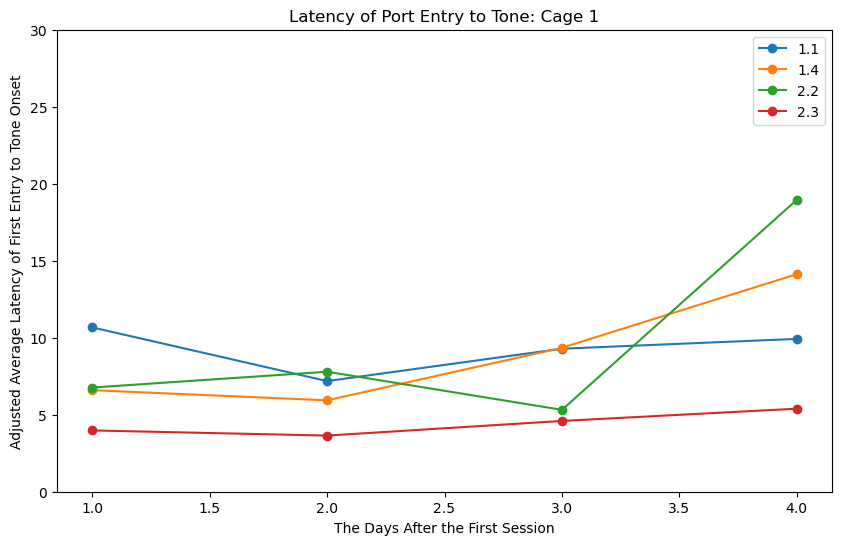

In [113]:
# Plotting for each cage
for cage in grouped_averaged_first_porty_entry_dataframe["cage"].unique():
    fig, ax = plt.subplots()
    # Getting all the rows with the current cage number
    cage_df = grouped_averaged_first_porty_entry_dataframe[grouped_averaged_first_porty_entry_dataframe["cage"] == cage]
    
    # Plotting a line for each subject
    for subject in cage_df["subject"].unique():
        # Getting all the rows with the current subject
        subject_df = cage_df[cage_df["subject"] == subject]
        # Making the dates into days after the first session by subtracting all the dates by the first date
        ax.plot(subject_df["date_int"] - subject_df["date_int"].min() + 1, subject_df["latency_adjusted_greater_than_30"], '-o', label=subject)

    # Setting the Y-Axis to only plot from 0 to 30 because we adjusted the latency to always be under 30
    ax.set_ylim(0, 30)
    # Labeling the X/Y Axis and the title
    ax.set_xlabel("The Days After the First Session")
    ax.set_ylabel("Adjusted Average Latency of First Entry to Tone Onset")
    ax.set_title("Latency of Port Entry to Tone: Cage {}".format(cage))
    # To show the legend
    ax.legend()
    file_name = "original_average_latency_plot_cage_{}_date_{}_{}.png".format(cage, earliest_date, latest_date)
    plt.savefig(os.path.join(original_average_latency_output_directory, file_name))

## Plotting the original ratio of latencies that are less than 10 seconds

In [114]:
less_than_10_second_original_latency_ratio_plots_output_directory = "./proc/plots/less_than_10_second_original_latency_ratio/cage_{}_date_{}_{}".format(cage_numbers_for_title, earliest_date, latest_date)

In [115]:
less_than_10_second_original_latency_ratio_plots_output_directory

'./proc/plots/less_than_10_second_original_latency_ratio/cage_1_date_20220508_20220512'

In [116]:
os.makedirs(less_than_10_second_original_latency_ratio_plots_output_directory, exist_ok=True)

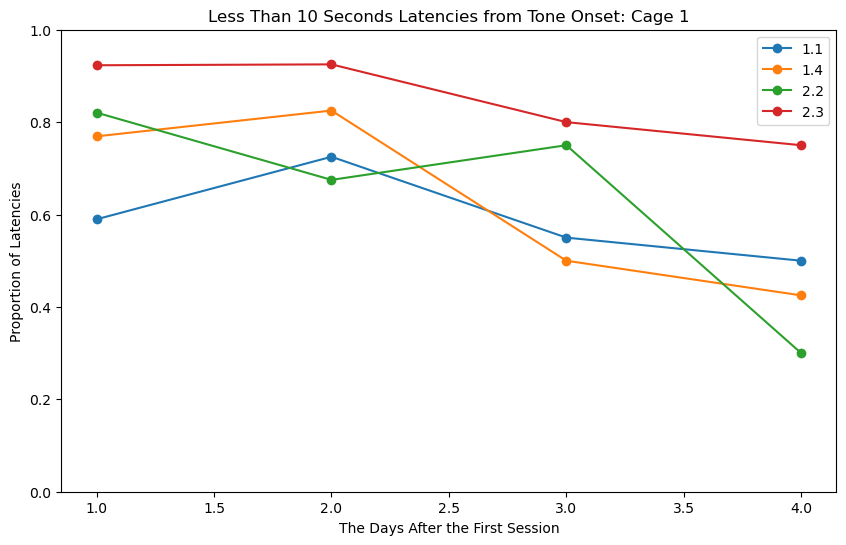

In [117]:
# Plotting for each cage
for cage in grouped_averaged_first_porty_entry_dataframe["cage"].unique():
    fig, ax = plt.subplots()
    # Getting all the rows with the current cage number
    cage_df = grouped_averaged_first_porty_entry_dataframe[grouped_averaged_first_porty_entry_dataframe["cage"] == cage]
    
    # Plotting a line for each subject
    for subject in cage_df["subject"].unique():
        # Getting all the rows with the current subject
        subject_df = cage_df[cage_df["subject"] == subject]
        # Making the dates into days after the first session by subtracting all the dates by the first date
        ax.plot(subject_df["date_int"] - subject_df["date_int"].min() + 1, subject_df["adjusted_30_second_latency_less_than_10_seconds_ratio"], '-o', label=subject)
    # Setting the Y-Axis to only plot from 0 to 30 because we adjusted the latency to always be under 30
    ax.set_ylim(0, 1)
    # Labeling the X/Y Axis and the title
    ax.set_xlabel("The Days After the First Session")
    ax.set_ylabel("Proportion of Latencies")
    ax.set_title("Less Than 10 Seconds Latencies from Tone Onset: Cage {}".format(cage))
    # To show the legend
    ax.legend()
    
    file_name = "less_than_10_second_original_latency_ratio_plot_cage_{}_date_{}_{}.png".format(cage, earliest_date, latest_date)
    plt.savefig(os.path.join(less_than_10_second_original_latency_ratio_plots_output_directory, file_name))


# Plotting the Adjusted Latencies for Entries that Overlap with the Tone

## Plotting the Latencies 

In [118]:
overlap_adjusted_average_latency_plots_output_directory = "./proc/plots/overlap_adjusted_average_latency_plots/cage_{}_date_{}_{}".format(cage_numbers_for_title, earliest_date, latest_date)

In [119]:
overlap_adjusted_average_latency_plots_output_directory

'./proc/plots/overlap_adjusted_average_latency_plots/cage_1_date_20220508_20220512'

In [120]:
os.makedirs(overlap_adjusted_average_latency_plots_output_directory, exist_ok=True)

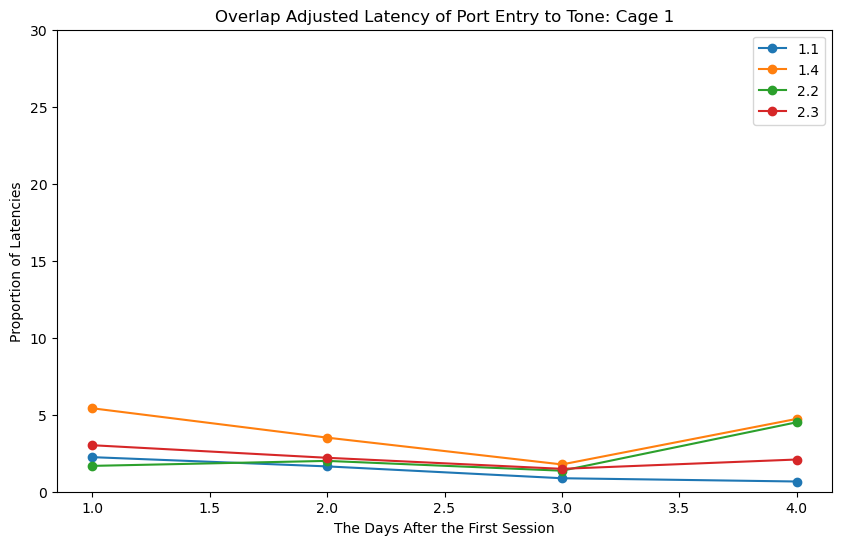

In [121]:
# Plotting for each cage
for cage in grouped_averaged_first_porty_entry_dataframe["cage"].unique():
    fig, ax = plt.subplots()
    # Getting all the rows with the current cage number
    cage_df = grouped_averaged_first_porty_entry_dataframe[grouped_averaged_first_porty_entry_dataframe["cage"] == cage]
    
    # Plotting a line for each subject
    for subject in cage_df["subject"].unique():
        # Getting all the rows with the current subject
        subject_df = cage_df[cage_df["subject"] == subject]
        # Making the dates into days after the first session by subtracting all the dates by the first date
        ax.plot(subject_df["date_int"] - subject_df["date_int"].min() + 1, subject_df["latency_adjusted_overlap"], '-o', label=subject)

    # Setting the Y-Axis to only plot from 0 to 30 because we adjusted the latency to always be under 30
    ax.set_ylim(0, 30)
    # Labeling the X/Y Axis and the title
    ax.set_xlabel("The Days After the First Session")
    ax.set_ylabel("Proportion of Latencies")
    ax.set_title("Overlap Adjusted Latency of Port Entry to Tone: Cage {}".format(cage))
    # To show the legend
    ax.legend()
    file_name = "overlap_adjusted_average_latency_plot_cage_{}_date_{}_{}.png".format(cage, earliest_date, latest_date)

    plt.savefig(os.path.join(overlap_adjusted_average_latency_plots_output_directory, file_name))


# Plotting the ratio of overlap adjusted latencies that are less than 10 seconds

In [122]:
less_than_10_second_overlap_adjusted_latency_ratio_output_directory = "./proc/plots/less_than_10_second_overlap_adjusted_latency_ratio/cage_{}_date_{}_{}".format(cage_numbers_for_title, earliest_date, latest_date)

In [123]:
less_than_10_second_overlap_adjusted_latency_ratio_output_directory

'./proc/plots/less_than_10_second_overlap_adjusted_latency_ratio/cage_1_date_20220508_20220512'

In [124]:
os.makedirs(less_than_10_second_overlap_adjusted_latency_ratio_output_directory, exist_ok=True)

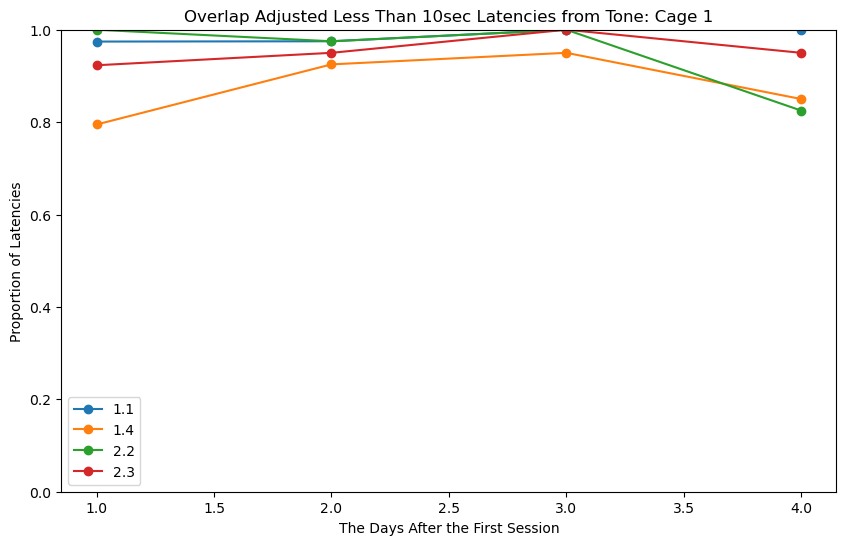

In [125]:
# Plotting for each cage
for cage in grouped_averaged_first_porty_entry_dataframe["cage"].unique():
    fig, ax = plt.subplots()
    # Getting all the rows with the current cage number
    cage_df = grouped_averaged_first_porty_entry_dataframe[grouped_averaged_first_porty_entry_dataframe["cage"] == cage]
    
    # Plotting a line for each subject
    for subject in cage_df["subject"].unique():
        # Getting all the rows with the current subject
        subject_df = cage_df[cage_df["subject"] == subject]
        # Making the dates into days after the first session by subtracting all the dates by the first date
        ax.plot(subject_df["date_int"] - subject_df["date_int"].min() + 1, subject_df["overlap_adjusted_latency_less_than_10_seconds"], '-o', label=subject)

    # Setting the Y-Axis to only plot from 0 to 30 because we adjusted the latency to always be under 30
    ax.set_ylim(0, 1)
    # Labeling the X/Y Axis and the title
    ax.set_xlabel("The Days After the First Session")
    ax.set_ylabel("Proportion of Latencies")
    ax.set_title("Overlap Adjusted Less Than 10sec Latencies from Tone: Cage {}".format(cage))
    # To show the legend
    ax.legend()
    
    file_name = "less_than_10_second_overlap_adjusted_latency_ratio_plot_cage{}_date_{}_{}.png".format(cage, earliest_date, latest_date)
    plt.savefig(os.path.join(less_than_10_second_overlap_adjusted_latency_ratio_output_directory, file_name))
